### MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils

# Try scipy to detrend
import segment as sg
import scipy
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

In [2]:
## User defined options
model = 'CLM5_GSWP3'
var  = ['GPP','TBOT','SOILWATER_10CM']
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file0 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[2] +'.185001-201412.nc'
file0

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc'

#### Read in data

In [3]:
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
# ?? TODO, is there a more efficient way of reading in multiple variables into a signle dataset??
ds0   = utils.time_set_mid(xr.open_dataset(file0, decode_times=True), 'time')
ds1   = utils.time_set_mid(xr.open_dataset(file1, decode_times=True), 'time')
ds2   = utils.time_set_mid(xr.open_dataset(file2, decode_times=True), 'time')
area = ds0.area
landfrac = ds0.landfrac
ds = xr.merge([ds0, ds1, ds2])
print(ds)

<xarray.Dataset>
Dimensions:         (hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1980)
Coordinates:
  * lat             (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * levdcmp         (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levgrnd         (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak          (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.325 44.775
  * lon             (lon) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * time            (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: hist_interval
Data variables:
    BSW             (levgrnd, lat, lon) float32 nan nan nan nan ... nan nan nan
    DZLAKE          (levlak, lat, lon) float32 nan nan nan nan ... nan nan nan
    DZSOI           (levgrnd, lat, lon) float32 0.02 0.02 0.02 ... nan nan nan
    GPP             (time, lat, lon) float32 ...
    HKSAT           (levgrnd, lat, lon) float32

### Quick look at annual cycle for a grid cell

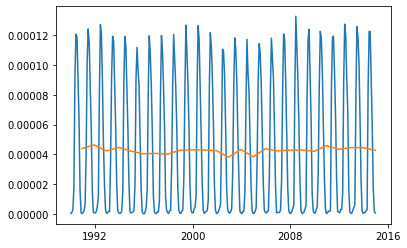

In [4]:
years = 25
months = years * 12
tlat =  60 #-5
tlon =  240# 300
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
dataset = ds_last.get(var)
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var[0]), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var[0]), '-' );

### Calculate climatology and anomalies

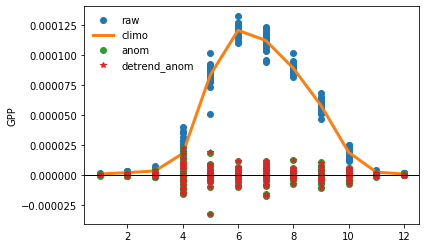

In [5]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend0 = signal.detrend(ds_anom.get(var[0]))
ds_detrend1 = signal.detrend(ds_anom.get(var[1]))
ds_detrend2 = signal.detrend(ds_anom.get(var[2]))

plt.plot(ds_last.time['time.month'], ds_last.get(var[0]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[0]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[0]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend0, '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[0]);


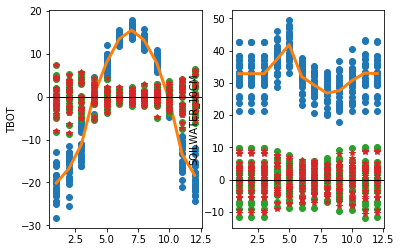

In [6]:
# now look at temp and soil moisture anomalies
plt.subplot(1, 2, 1)
plt.plot(ds_last.time['time.month'], ds_last.get(var[1])-273.15, 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[1])-273.15, '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[1]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend1, '*' );
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[1])

plt.subplot(1, 2, 2)
plt.plot(ds_last.time['time.month'], ds_last.get(var[2]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[2]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[2]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend2, '*' );
plt.axhline(0., color='black', lw=1);
plt.ylabel(var[2]);

 ### Do we need to detrend data?

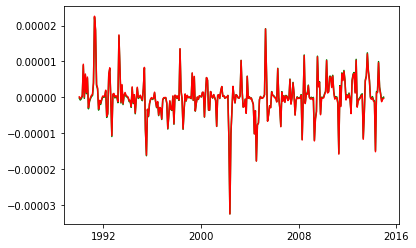

In [7]:
plt.plot(ds_anom.time['time'], ds_anom.get(var[0]), '-',c='green' )
plt.plot(ds_anom.time['time'], ds_detrend0, '-' ,c='red');

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

(12, 25)


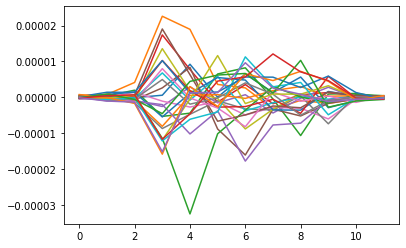

In [8]:
# orig. mon x year
iavmatrix_0 =np.zeros([12, years])
iavmatrix_1 =np.zeros([12, years])
iavmatrix_2 =np.zeros([12, years])
for iyr in range(years):
    iavmatrix_0[0:12, iyr]=ds_detrend0[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_1[0:12, iyr]=ds_detrend1[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
    iavmatrix_2[0:12, iyr]=ds_detrend2[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 

monthlimits=np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
DOYlimits=np.cumsum(monthlimits)
print(iavmatrix_0.shape)

plt.figure();
plt.plot(iavmatrix_0) ; #this plots months on x-axis, 1 line/year

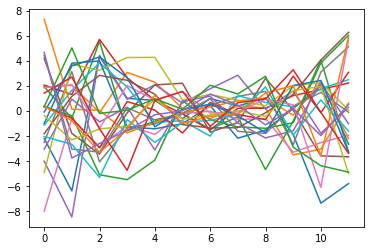

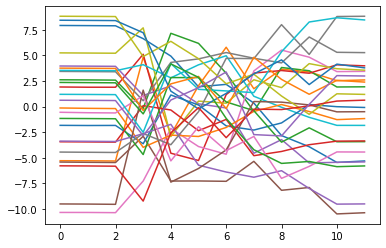

In [9]:
plt.figure();
plt.plot(iavmatrix_1) ; #this plots months on x-axis, 1 line/year
plt.figure();
plt.plot(iavmatrix_2) ; #this plots months on x-axis, 1 line/year


### Now try using SVD_tools.py

In [10]:
import SVD_tools as svd
#assign the 2-D matrix (month x year) to decompose
## TODO, the decompose functions doesn't like to work with too many years of data?  
[vectors, weights]=svd.decompose(iavmatrix_0) #Call the function to calculate the singular vectors and their annual weights
[vectors1, weights1]=svd.decompose(iavmatrix_1) 
[vectors2, weights2]=svd.decompose(iavmatrix_2) 
print(vectors.shape)

[theta ,varfrac] =svd.calc_redistribution(vectors , weights , iavmatrix_0)
[theta1,varfrac1]=svd.calc_redistribution(vectors1, weights1, iavmatrix_1)
[theta2,varfrac2]=svd.calc_redistribution(vectors2, weights2, iavmatrix_2)
varfrac.shape

(25, 12)


/glade/u/home/wwieder/python/ctsm_py/notebooks/SVD_tools.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sv_theta[i] = np.abs(np.nansum(sv_vectors[i,:]))/np.nansum(np.abs(sv_vectors[i,:]))


(25,)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1.4840747001486394e-05


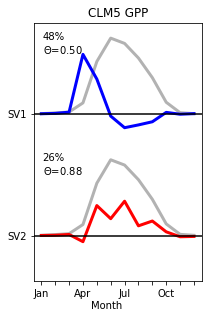

In [11]:
##Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
print(ymax)
vectors2plot=vectors*5000  #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var[0])
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.55,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0]))
ax1.text(0.5,.15,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1]))
ax1.title.set_text('CLM5 '+var[0])
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_CLM5_ex_GPP.eps') ;


1.4840747001486394e-05
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 59.842934
    lon      float32 240.0
Data variables:
    r        float64 -5.836e-18
    p        float64 1.0
[[1.         0.17786995]
 [0.17786995 1.        ]]
[[ 1.         -0.84945569]
 [-0.84945569  1.        ]]


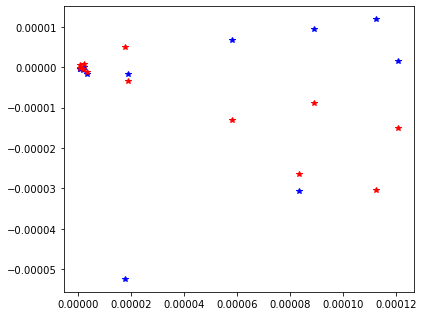

In [12]:
# Can correlations between climatology and Vectors tell us someting about the nature of relationships?
fig = plt.figure(4,figsize=(6,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
print(ymax)
#mm2plot=mm
mm2plot=ds_climo.get(var[0])
ax1.plot(mm2plot, vectors[0,:], '*',c='b')
ax1.plot(mm2plot, vectors[1,:], '*',c='r')
plt.tight_layout()
x  = xr.DataArray(data=mm2plot)
y0 = xr.DataArray(data=vectors[0,:])
y1 = xr.DataArray(data=vectors[1,:])
temp = esmlab.statistics.weighted_corr(x,y1  )
print(temp)
cor1 = np.corrcoef(mm2plot,vectors[0,:])
cor2 = np.corrcoef(mm2plot,vectors[1,:])
print(cor1 )
print(cor2 )

In [13]:
# also try spearman's rank correlation
from scipy.stats import spearmanr
corr, _ = spearmanr(mm2plot,vectors[0,:])
print('Spearmans correlation: %.3f' % corr)


Spearmans correlation: 0.399


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


13.212490332557676
17.971212879125858


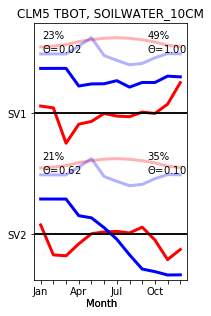

In [14]:
## Temperature, Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors1)
print(ymax)
vectors2plot=vectors1 *0.01 #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var[1])
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'r-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'r-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'r-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.55,str(int(varfrac1[0]*100))+"%\n$\Theta$="+str('%.2f'%theta1[0]))
ax1.text(0.5,.15,str(int(varfrac1[1]*100))+"%\n$\Theta$="+str('%.2f'%theta1[1]))
ax1.title.set_text('CLM5 '+var[1]+", "+var[2])
ax1.text(4,-0.29,'Month')
plt.tight_layout();

ax2 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors2)
print(ymax)
vectors2plot=vectors2 *0.01 #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var[2])
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'b-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'b-',alpha=0.3,linewidth=3)
ax2.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax2.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'b-',linewidth=3)
ax2.axhline(-0.05,color='black')
ax2.axhline(0.35,color='black')
ax2.set_xticks(np.array(month)+2*barwidth)
ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax2.set_yticks([-0.05,0.35])
ax2.set_yticklabels(['SV2','SV1'])
ax2.set_ylim([-0.2,0.65])
ax2.text(8.8,.55,str(int(varfrac2[0]*100))+"%\n$\Theta$="+str('%.2f'%theta2[0]))
ax2.text(8.8,.15,str(int(varfrac2[1]*100))+"%\n$\Theta$="+str('%.2f'%theta2[1]))
ax1.title.set_text('CLM5 '+var[1]+", "+var[2])
ax2.text(4,-0.29,'Month')

plt.tight_layout();
plt.savefig('SVD_CLM5_ex_climo.eps') ;


## Calculate global anomalies

In [15]:
ds2 = ds.isel(time=slice(-months,None))             # Select last N years of data
ds_climo = esmlab.core.climatology(ds2,freq='mon')  # Calculate climatology
ds_anom  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
anom_0    = ds_anom.get(var[0]).values              # returns a 3d array with dims (time,lat,lon)
# print(ds_anom2)    
print(anom_0.shape)

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(300, 192, 288)


#### Define wrapper function that includes: 
- Detrending, reshaping, SVD & 
- Returns a np.array with vectors, weights, theta & varfrac

In [16]:
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (year x month) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights

In [17]:
'''#select a single grid point to work with first
ds_temp = ds_anom.sel(lat=tlat, lon=tlon, method='nearest') 
#print(ds_temp.get(var[0]))

# Make sure wrapper results are the same as above
[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)
plt.plot(theta_wrap - theta, '*') ;
plt.plot(varfrac_wrap - varfrac, '*',c='r') ;
print ('differences between results look prety small')

'''

"#select a single grid point to work with first\nds_temp = ds_anom.sel(lat=tlat, lon=tlon, method='nearest') \n#print(ds_temp.get(var[0]))\n\n# Make sure wrapper results are the same as above\n[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)\nplt.plot(theta_wrap - theta, '*') ;\nplt.plot(varfrac_wrap - varfrac, '*',c='r') ;\nprint ('differences between results look prety small')\n\n"

#### Make frunction to Loop through each grid cell & dataset to save output
- Would Dask make this faster?
- how do we also mask non-veg land cells?


In [18]:
def calc_svd(da, nyears=years):
 #   print(da)
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    theta_shape = yx_shape + (nyears, )
    vector_shape = yx_shape + (nyears, 12)
    weights_shape = yx_shape + (nyears, nyears)
    
    out = xr.Dataset( coords={"lat": da.lat, "lon": da.lon } )

    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'vectors_dim1', 'time'))
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'weights_dim1', 'weights_dim2'))
 #   print(out)
 #   if da.size == 0:
 #       return out

    # loop over all i,j points
    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    #out.assign_coords(lon=da.lon)
    #out.assign_coords(lat=da.lat)
                         
    return out

In [19]:
%%time
# Now try this on the full dataset
# generate data arrays from anomaly data to feed into function
da0 = ds_anom.get(var[0])  
da1 = ds_anom.get(var[1])  
da2 = ds_anom.get(var[2])  

#da0 = da0.chunk({'lat':50, 'lon':50})
#print(da0)
#svd0 = da0.map_blocks(calc_svd)
#print(svd0)
# this step is slow, but seems to be working?

CPU times: user 108 µs, sys: 106 µs, total: 214 µs
Wall time: 221 µs


In [20]:
#svd0.compute()

In [21]:
%%time
svd0 = calc_svd(da0)  # GPP 
svd1 = calc_svd(da1)  # temp 
print(svd1)
svd2 = calc_svd(da2)  # soil moisture
print(svd2)

/glade/u/home/wwieder/python/ctsm_py/notebooks/SVD_tools.py:60: RuntimeWarning: invalid value encountered in double_scalars
  sv_theta[i] = np.abs(np.nansum(sv_vectors[i,:]))/np.nansum(np.abs(sv_vectors[i,:]))
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, thetadim: 25, time: 12, vectors_dim1: 25, weights_dim1: 25, weights_dim2: 25)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: thetadim, time, vectors_dim1, weights_dim1, weights_dim2
Data variables:
    theta    (lat, lon, thetadim) float64 1.0 0.05236 0.1133 ... 0.0 0.0 0.0
    varfrac  (lat, lon, thetadim) float64 0.822 0.04716 0.03308 ... 0.0 0.0 0.0
    vectors  (lat, lon, vectors_dim1, time) float64 -21.7 -22.1 ... 0.0 0.0
    weights  (lat, lon, weights_dim1, weights_dim2) float64 -0.2966 ... 0.0


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, thetadim: 25, time: 12, vectors_dim1: 25, weights_dim1: 25, weights_dim2: 25)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: thetadim, time, vectors_dim1, weights_dim1, weights_dim2
Data variables:
    theta    (lat, lon, thetadim) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    varfrac  (lat, lon, thetadim) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vectors  (lat, lon, vectors_dim1, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    weights  (lat, lon, weights_dim1, weights_dim2) float64 0.0 0.0 ... 0.0 0.0
CPU times: user 11min 43s, sys: 461 ms, total: 11min 43s
Wall time: 11min 43s


In [22]:
# rearrange output & write out to scratch
svd0['theta']   = svd0.theta.transpose('thetadim','lat','lon')
svd0['varfrac'] = svd0.varfrac.transpose('thetadim','lat','lon')
svd0['vectors'] = svd0.vectors.transpose('time', 'vectors_dim1','lat','lon')
svd0['weights'] = svd0.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
svd0['climatology'] = ds_climo.GPP
print(svd0)
svd0.to_netcdf(path='/glade/scratch/wwieder/svd/svd0_gpp.nc') 

<xarray.Dataset>
Dimensions:      (lat: 192, lon: 288, thetadim: 25, time: 12, vectors_dim1: 25, weights_dim1: 25, weights_dim2: 25)
Coordinates:
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: thetadim, vectors_dim1, weights_dim1, weights_dim2
Data variables:
    theta        (thetadim, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0
    varfrac      (thetadim, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vectors      (time, vectors_dim1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    weights      (weights_dim1, weights_dim2, lat, lon) float64 1.0 1.0 ... 0.0
    climatology  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan


In [23]:
svd1['theta']   = svd1.theta.transpose('thetadim','lat','lon')
svd1['varfrac'] = svd1.varfrac.transpose('thetadim','lat','lon')
svd1['vectors'] = svd1.vectors.transpose('time', 'vectors_dim1','lat','lon')
svd1['weights'] = svd1.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
svd1['climatology'] = ds_climo.TBOT
svd1.to_netcdf(path='/glade/scratch/wwieder/svd/svd1_tbot.nc') 

svd2['theta']   = svd2.theta.transpose('thetadim','lat','lon')
svd2['varfrac'] = svd2.varfrac.transpose('thetadim','lat','lon')
svd2['vectors'] = svd2.vectors.transpose('time', 'vectors_dim1','lat','lon')
svd2['weights'] = svd2.weights.transpose('weights_dim1', 'weights_dim2','lat','lon')
svd2['climatology'] = ds_climo.SOILWATER_10CM
svd2.to_netcdf(path='/glade/scratch/wwieder/svd/svd2_soilwater.nc') 


### Correlations between vectors and climatology
example from http://xarray.pydata.org/en/stable/dask.html

In [24]:
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def pearson_correlation(x, y, dim):
    return xr.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])


In [41]:
# subset data arrays for processing & shape correctly
GPPclimo = ds_climo.GPP
GPPvector_0 = svd0.vectors[:,0,:,:]
GPPvector_1 = svd0.vectors[:,1,:,:]
TBOTvector_0 = svd1.vectors[:,0,:,:]
TBOTvector_1 = svd1.vectors[:,1,:,:]
SMOIvector_0 = svd2.vectors[:,0,:,:]
SMOIvector_1 = svd2.vectors[:,1,:,:]
GPPclimo['time'] = GPPvector_0 = svd0.time  # get time coords to match

# now calculate the correlations
GPPp_0 = pearson_correlation(GPPclimo, GPPvector_0, 'time')
GPPr_0 = spearman_correlation(GPPclimo, GPPvector_0, 'time')
GPPr_1 = spearman_correlation(GPPclimo, GPPvector_1, 'time')

GPP_0_TBOT_0 = spearman_correlation(GPPvector_0, TBOTvector_0,'time')
GPP_0_SMOI_0 = spearman_correlation(GPPvector_0, SMOIvector_0,'time')
GPP_0_TBOT_1 = spearman_correlation(GPPvector_0, TBOTvector_1,'time')
GPP_0_SMOI_1 = spearman_correlation(GPPvector_0, SMOIvector_1,'time')

GPP_1_TBOT_0 = spearman_correlation(GPPvector_1, TBOTvector_0,'time')
GPP_1_SMOI_0 = spearman_correlation(GPPvector_1, SMOIvector_0,'time')
GPP_1_TBOT_1 = spearman_correlation(GPPvector_1, TBOTvector_1,'time')
GPP_1_SMOI_1 = spearman_correlation(GPPvector_1, SMOIvector_1,'time')

print(GPPr_0)
print(xr.ufuncs.fabs(GPPr_0))

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


<xarray.DataArray (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
<xarray.DataArray (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


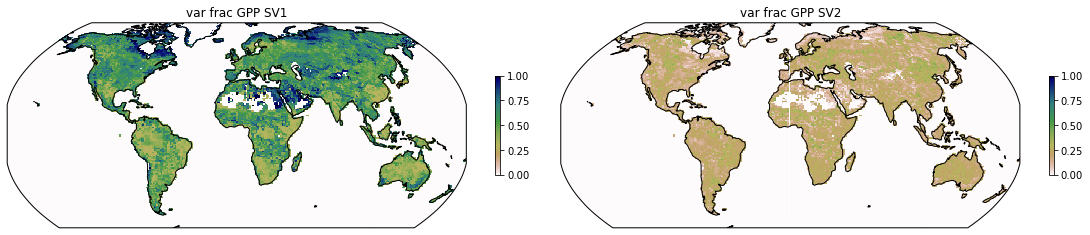

In [46]:
# just look at fraction of variance explained in GPP for each vector

import matplotlib.colors as colors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

vmax = 1.
vmin = 0

fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(svd0.lon.values,svd0.lat.values,svd0.varfrac.values[0,:,:],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('var frac GPP SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(svd0.lon.values,svd0.lat.values,svd0.varfrac.values[1,:,:],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('var frac GPP SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()


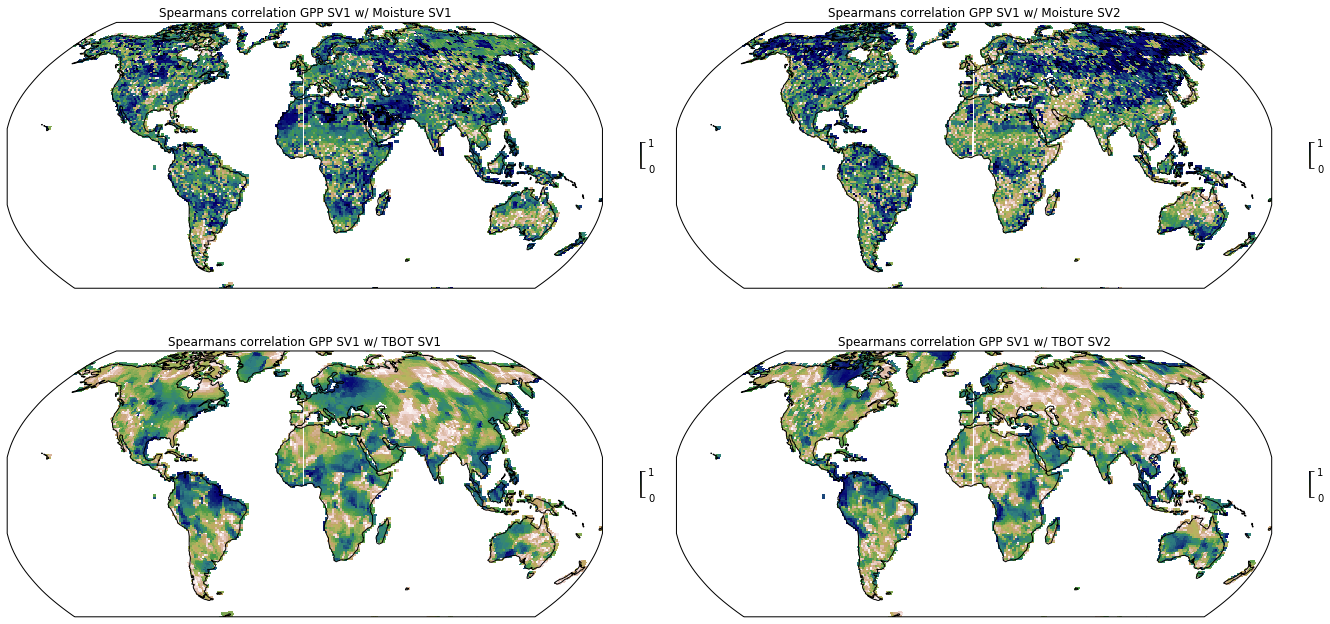

In [47]:
# plot correlations with soil moisture & Temp
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(GPP_0_SMOI_0.lon.values,GPP_0_SMOI_0.lat.values,xr.ufuncs.fabs(GPP_0_SMOI_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('Spearmans correlation GPP SV1 w/ Moisture SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(2,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(GPP_0_SMOI_1.lon.values,GPP_0_SMOI_1.lat.values,xr.ufuncs.fabs(GPP_0_SMOI_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('Spearmans correlation GPP SV1 w/ Moisture SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

ax3 = fig.add_subplot(2,2,3,projection=ccrs.Robinson())
im3 = ax3.pcolormesh(GPP_0_TBOT_0.lon.values,GPP_0_TBOT_0.lat.values,xr.ufuncs.fabs(GPP_0_TBOT_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im3,ax=ax3,shrink=0.07,label='')
ax3.coastlines()
ax3.set_title('Spearmans correlation GPP SV1 w/ TBOT SV1')
ax3.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(2,2,4,projection=ccrs.Robinson())
im4 = ax4.pcolormesh(GPP_0_TBOT_1.lon.values,GPP_0_TBOT_1.lat.values,xr.ufuncs.fabs(GPP_0_TBOT_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im4,ax=ax4,shrink=0.07,label='')
ax4.coastlines()
ax4.set_title('Spearmans correlation GPP SV1 w/ TBOT SV2')
ax4.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()

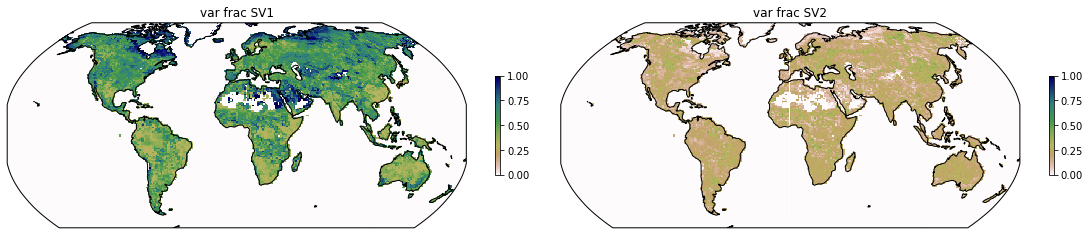

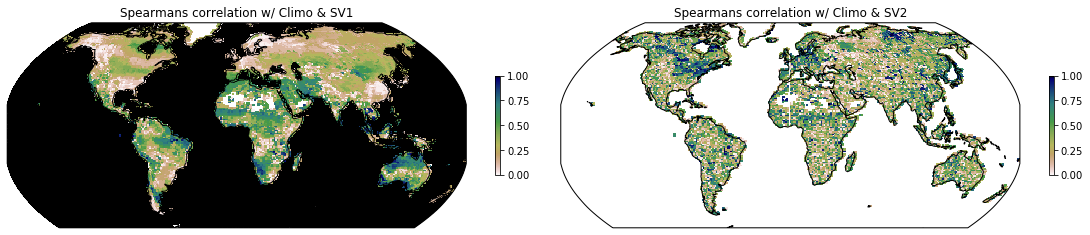

In [44]:
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(GPPr_0.lon.values,GPPr_0.lat.values,xr.ufuncs.fabs(GPPr_0),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('Spearmans correlation w/ Climo & SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(GPPr_1.lon.values,GPPr_1.lat.values,xr.ufuncs.fabs(GPPr_1),transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('Spearmans correlation w/ Climo & SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()



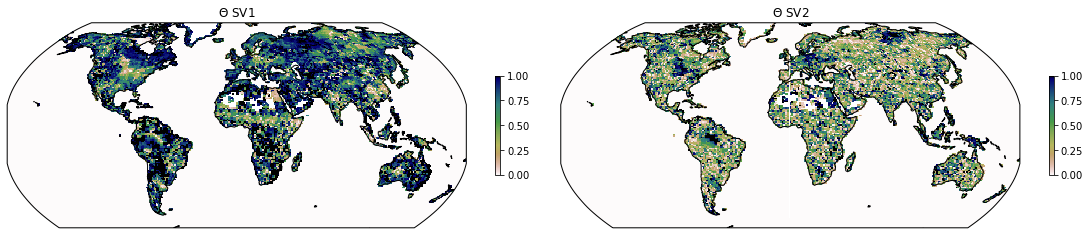

In [70]:
vmax = 1.
vmin = 0.
fig = plt.figure(figsize=(16,20))

ax1 = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
im1 = ax1.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,0],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im1,ax=ax1,shrink=0.07,label='')
ax1.coastlines()
ax1.set_title('$\Theta$ SV1')
ax1.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())

ax2 = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
im2 = ax2.pcolormesh(svd2.lon.values,svd2.lat.values,svd0.theta.values[:,:,1],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap='gist_earth_r')
fig.colorbar(im2,ax=ax2,shrink=0.07,label='')
ax2.coastlines()
ax2.set_title('$\Theta$ SV2')
ax2.set_extent([-180,180,-65,80],crs=ccrs.PlateCarree())
fig.tight_layout()


<Figure size 360x252 with 0 Axes>

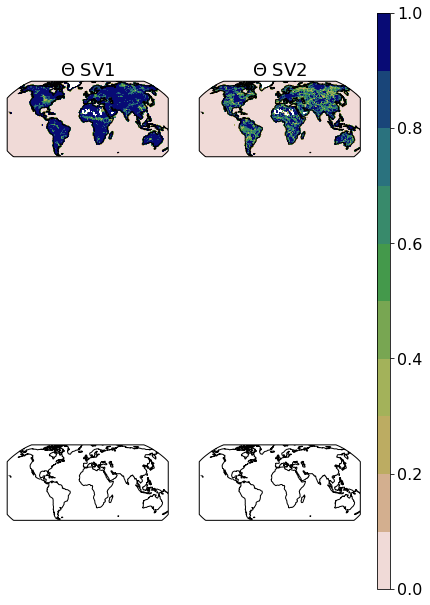

In [72]:
lat = svd2.coords['lat']
lon = svd2.coords['lon']
x0 = svd0.theta[:,:,0]
x1 = svd0.theta[:,:,1]

norm = colors.Normalize(vmin=0, vmax=1.)

# modified from https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
crs = ccrs.Robinson()#central_longitude=305.0)

# Function used to create the map subplots
def plot_background(ax):
    ax.set_global()
    ax.coastlines()
    #ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

levels = np.linspace(0, 1, 11)
fig = plt.figure(figsize=(5, 3.5),constrained_layout=True);
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(6, 10), constrained_layout=True,
                          subplot_kw={'projection': crs})

axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
    ax.set_extent([-155, 60, -25, 60])  # I really don't understand how this works??
#    ax.set_extent([-150, 60, -25, 60])


# upper plot
cf0 = axlist[0].contourf(lon, lat, x0, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[0].set_title('$\Theta$ SV1', fontsize=18)
axlist[0].set_axis_off()

# lower plot
cf1 = axlist[1].contourf(lon, lat, x1, levels=levels, norm=norm, cmap='gist_earth_r',
                 transform=ccrs.PlateCarree());
axlist[1].set_title('$\Theta$ SV2', fontsize=18)
axlist[1].set_axis_off()

# add common colorbar
cbar = fig.colorbar(cf1, ax=axlist.ravel().tolist(), 
                    orientation='vertical', shrink=0.80, pad=0)
#cbar.set_label('gC/m2/y', size=18, orientation='horizontal')
cbar.ax.tick_params(labelsize=16) 
ax = cbar.ax
#ax.text(0.2,-0.1,mean_dataset.attrs['units'], size=16,rotation=0)
plt.show();
